# 2D ring resonator

This is a simple example of using Tidy3D to perform a 2D simulation of a ring resonator side coupled to a dielectric waveguide.

<img src="img/ring.png" alt="diagram" width="300"/>

With a center wavelength of 500 nm and 10 nm resolution, this is a challenging FDTD problem because of the large simulation size.  The simulation contains 1 million grid points to model the entire domain and 290,000 time steps to capture the resonance of the ring.

With Tidy3D, we perform each simulation in just a few minutes.

In [1]:
# standard python imports
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

# tidy3D import
import tidy3d.web as web
import tidy3d as td

Using Tidy3D credentials from stored file


## Initial setup

Our ring resonator will include a ring centered at (0,0) with a waveguide just above the ring spanning the x direction.

```    
                      (waveguide)      
                in -> ========== -> out
                           0
                      (resonator)
   ```

In [2]:
# resolution
dl = 0.01

# define geometry
wg_width = 0.25
couple_width = 0.05
ring_radius = 3.5
ring_wg_width = 0.25
wg_spacing = 2.0
buffer = 2.0

# compute quantities based on geometry parameters
x_span = 2*wg_spacing + 2*ring_radius + 2*buffer
y_span = 2*ring_radius + 2*ring_wg_width + wg_width + couple_width + 2*buffer
wg_insert_x = ring_radius + wg_spacing
wg_center_y = ring_radius + ring_wg_width/2. + couple_width + wg_width/2.

# set number of PMLs on each side
npml = 15

In [3]:
# define pulse parameters
lambda0 = 1.0
freq0 = td.C_0 /lambda0
fwidth =  freq0 / 6
grids_per_wavelength = lambda0 / dl
run_time_norm = 1e-13  # run time for normalization run without ring
run_time = 5e-12       # run time for simulation with ring

Define materials. [(docs)](https://simulation.cloud/docs/html/api.html#material)

In [4]:
n_bg = 1.0
n_solid = 1.5
background = td.Medium(permittivity=n_bg**2)
solid = td.Medium(permittivity=n_solid**2)

Define structures. [(docs)](https://simulation.cloud/docs/html/api.html#structure)


In [5]:
# background of entire domain (set explicitly as a box)
background_box = td.Structure(
    geometry=td.Box(
        center=[0, 0, 0],
        size=[td.inf, td.inf, td.inf],
    ),
    medium=background,
    name='background')

# waveguide
waveguide = td.Structure(
    geometry=td.Box(
        center=[0, wg_center_y, 0],
        size=[td.inf, wg_width, td.inf],
    ),
    medium=solid,
    name='waveguide')

# outside ring
outer_ring = td.Structure(
    geometry=td.Cylinder(
        center=[0,0,0],
        axis=2,
        radius=ring_radius+ring_wg_width/2.0,
        length=td.inf,
    ),
    medium=solid,
    name='outer_ring')

# inside ring fill
inner_ring = td.Structure(
    geometry=td.Cylinder(
        center=[0,0,0],
        axis=2,
        radius=ring_radius-ring_wg_width/2.0,
        length=td.inf,
    ),
    medium=background,
    name='inner_ring')

In [6]:
from tidy3d.plugins import ModeSolver

mode_plane = td.Box(
    center=[-wg_insert_x, wg_center_y, 0],
    size=[0, 2, td.inf],
)

sim_modesolver = td.Simulation(
    size=[x_span, y_span, 1*dl],
    grid_size=[dl, dl, dl],
    structures=[background_box, waveguide],
)

mode_solver = ModeSolver(simulation=sim_modesolver, plane=mode_plane, freq=freq0)
mode_data = mode_solver.solve(mode_spec=td.ModeSpec(num_modes=2))

mode_data_0, mode_data_1 = mode_data

mode_data_0.field_data.Ey

<xarray.Tidy3dDataArray (x: 1, y: 201, z: 1, f: 1)>
array([[[[-3.43501164e-15-3.33114395e-15j]],

 [[-3.86407255e-15-3.61204993e-15j]],

 [[-3.89012835e-15-3.74401588e-15j]],

 [[-3.24470693e-15-2.32651210e-15j]],

 [[-2.72209136e-15-4.19145976e-16j]],

 [[-2.90084191e-15-6.47152735e-16j]],

 [[-2.38142993e-15+7.40850450e-16j]],

 [[-1.60560451e-15+2.18782205e-16j]],

 [[-4.36142367e-16+1.92822333e-15j]],

 [[-3.18775710e-16+1.84147820e-15j]],

...

 [[-2.07036080e-15-9.49901712e-16j]],

 [[-2.65024554e-15+5.40124635e-16j]],

 [[-2.46063128e-15-3.13579990e-17j]],

 [[-1.57948770e-15+3.73421505e-16j]],

 [[-1.36521773e-15-5.53307523e-16j]],

 [[-1.00442089e-15-6.28669310e-16j]],

 [[-1.92683195e-15-7.67044579e-16j]],

 [[-2.34487888e-15-1.22737958e-15j]],

 [[-2.31710468e-15-2.05495535e-15j]],

 [[-1.30676602e-15-2.27608231e-15j]]]])
Coordinates:
 * x (x) float64 -5.5
 * y (y) float64 2.795 2.805 2.815 2.825 ... 4.765 4.775 4.785 4.795
 * z (z) float64 -0.005
 * f (f) float64 2.998e+14 xarray.Tidy3dDataArray x : 1 y : 201 z : 1 f : 1 (-3.4350116396648405e-15-3.3311439457099306e-15j) ... (-1.306766020... array([[[[-3.43501164e-15-3.33114395e-15j]],

 [[-3.86407255e-15-3.61204993e-15j]],

 [[-3.89012835e-15-3.74401588e-15j]],

 [[-3.24470693e-15-2.32651210e-15j]],

 [[-2.72209136e-15-4.19145976e-16j]],

 [[-2.90084191e-15-6.47152735e-16j]],

 [[-2.38142993e-15+7.40850450e-16j]],

 [[-1.60560451e-15+2.18782205e-16j]],

 [[-4.36142367e-16+1.92822333e-15j]],

 [[-3.18775710e-16+1.84147820e-15j]],

...

 [[-2.07036080e-15-9.49901712e-16j]],

 [[-2.65024554e-15+5.40124635e-16j]],

 [[-2.46063128e-15-3.13579990e-17j]],

 [[-1.57948770e-15+3.73421505e-16j]],

 [[-1.36521773e-15-5.53307523e-16j]],

 [[-1.00442089e-15-6.28669310e-16j]],

 [[-1.92683195e-15-7.67044579e-16j]],

 [[-2.34487888e-15-1.22737958e-15j]],

 [[-2.31710468e-15-2.05495535e-15j]],

 [[-1.30676602e-15-2.27608231e-15j]]]]) Coordinates: (4) x (x) float64 -5.5 units : um long_name : x position array([-5.5]) y (y) float64 2.795 2.805 2.815 ... 4.785 4.795 units : um long_name : y position array([2.795, 2.805, 2.815, ..., 4.775, 4.785, 4.795]) z (z) float64 -0.005 units : um long_name : z position array([-0.005]) f (f) float64 2.998e+14 units : Hz long_name : frequency array([2.997925e+14]) Attributes: (0)

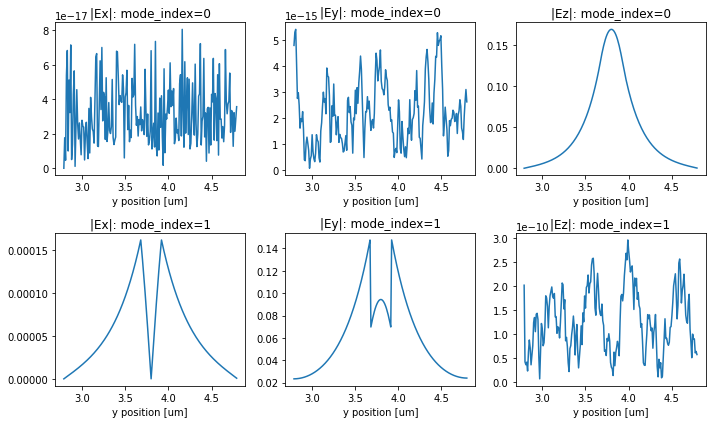

In [7]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, tight_layout=True, figsize=(10, 6))
abs(mode_data_0.field_data.Ex).plot(ax=ax1)
abs(mode_data_0.field_data.Ey).plot(ax=ax2)
abs(mode_data_0.field_data.Ez).plot(ax=ax3)
abs(mode_data_1.field_data.Ex).plot(ax=ax4)
abs(mode_data_1.field_data.Ey).plot(ax=ax5)
abs(mode_data_1.field_data.Ez).plot(ax=ax6)
ax1.set_title('|Ex|: mode_index=0')
ax2.set_title('|Ey|: mode_index=0')
ax3.set_title('|Ez|: mode_index=0')
ax4.set_title('|Ex|: mode_index=1')
ax5.set_title('|Ey|: mode_index=1')
ax6.set_title('|Ez|: mode_index=1')
plt.show()

From the above plots, we see that 

`mode_index=0` corresponds to exciting 0-th order TM mode (E=Ez) and 

`mode_index=1` corresponds to exciting 0-th order TE mode (E=Ey).

We can therefore switch the mode index accordingly based on our polarization.

Let's select Ey and create the source for it.

In [8]:
# mode_source = mode_solver.to_source(mode_spec=td.ModeSpec(num_modes=2), fwidth=fwidth, direction="+")
mode_source = td.ModeSource(
    size=mode_plane.size,
    center=mode_plane.center,
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    mode_spec=td.ModeSpec(num_modes=2),
    mode_index=1,
    direction='+'
)

In addition, let's monitor both the fields in plane as well as the output mode amplitudes into the fundamental TE mode.

In [9]:
# monitor steady state fields at central frequency over whole domain
field_monitor = td.FieldMonitor(
    center=[0, 0, 0],
    size=[td.inf, td.inf, 0],
    freqs=[freq0],
    name='field')

# monitor the mode amps on the output waveguide
lambdas_measure = np.linspace(0.8, 1.1, 1001)
freqs_measure = td.C_0 / lambdas_measure
# mode_monitor = mode_solver.to_monitor(mode=td.Mode(mode_index=1), freqs=freqs_measure, name='mode')
mode_monitor = td.ModeMonitor(
    size=mode_plane.size,
    center=mode_plane.center,
    freqs=freqs_measure,
    mode_spec=td.ModeSpec(num_modes=2),
    name='mode'
)

# lets reset the center to the on the right hand side of the simulation though
mode_monitor.center = [+wg_insert_x, wg_center_y, 0]

Define simulation. [(docs)](https://simulation.cloud/docs/html/api.html#simulation)

Here, we turn off the automatic shutoff factor by setting it to 0. This is because we will compute the spectrum by a fourier transform of the time response, and we would like to run the normalization simulation and the simulation with ring to exactly the same `run_time`.

In [10]:
# create normalization simulation (no ring)
sim0 = td.Simulation(
    size=[x_span, y_span, 1*dl],
    grid_size=[dl, dl, dl],
    structures=[background_box, waveguide],
    sources=[mode_source],
    monitors=[field_monitor, mode_monitor],
    run_time = run_time_norm,
    pml_layers=[td.PML(), td.PML(), None])

# create simulation (with ring)
sim = td.Simulation(
    size=[x_span, y_span, 1*dl],
    grid_size=[dl, dl, dl],
    structures=[background_box, waveguide, outer_ring, inner_ring],
    sources=[mode_source],
    monitors=[field_monitor, mode_monitor],
    run_time = run_time,
    pml_layers=[td.PML(), td.PML(), None])

----
Visualize structure, source, and modes. [(docs)](https://simulation.cloud/docs/html/api.html#plotting-tools)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


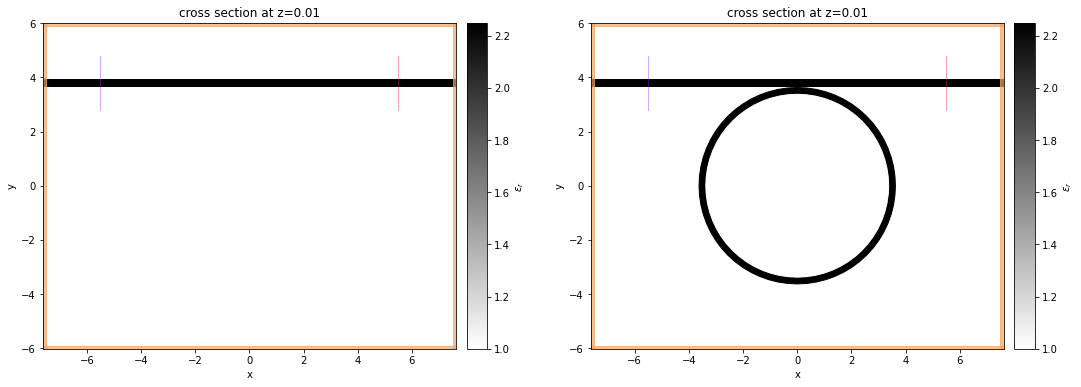

In [11]:
# plot the two simulations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sim0.plot_eps(z=0.01, ax=ax1)
sim.plot_eps(z=0.01, ax=ax2)
plt.show()

----
## Run Simulation
Run simulations on our server. [(docs)](https://simulation.cloud/docs/html/api.html#web-api)

In [ ]:
# use function above to run simulation with and without ring
sim_data0 = web.run(sim0, task_name='normalization', path='data/simulation_data0.hdf5')
sim_data = web.run(sim, task_name='with_ring', path='data/simulation_data.hdf5')

[16:30:59] INFO     Uploaded task 'normalization' with task_id                  ]8;id=498054;file://../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=23341;file://../../tidy3d/tidy3d/web/webapi.py#109\109]8;;\
                    'ac89e7af-44f9-413f-86ce-4b477b62fd56'.

Output()

[16:31:00] status = queued                                                      ]8;id=592871;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=669531;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#201\201]8;;\

[16:33:17] status = running                                                     ]8;id=769265;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=13458;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#201\201]8;;\

[16:57:26] status = visualize                                                   ]8;id=904975;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=640236;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#201\201]8;;\

[16:57:39] status = success                                                     ]8;id=633032;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=400202;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#201\201]8;;\

In [ ]:
print(sim_data.log)

In [ ]:
# visualize normalization run
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, tight_layout=True, figsize=(15, 10))
im = sim_data0.plot_field('field', 'Ex', val='real', z=0, freq=freq0, ax=ax1)
im = sim_data0.plot_field('field', 'Ey', val='real', z=0, freq=freq0, ax=ax2)
im = sim_data.plot_field('field', 'Ex', val='real', z=0, freq=freq0, ax=ax3)
im = sim_data.plot_field('field', 'Ey', val='real', z=0, freq=freq0, ax=ax4)

## Analyze Spectrum

Now let's analyze the mode amplitudes in the output waveguide.

First, let's grab the data to inspect it.

In [ ]:
sim_data['mode']

As we see, the mode amplitude data is complex-valued with three 3 dimensions:
* index into the mode order returned by solver (remember, we wanted mode_index=1 for fundamental TE).
* direction of the propagation (for decomposition).
* frequency.

Let's select into the first two dimensions to get mode amplitudes as a function of frequency and divide the results with a ring by the normalization.

In [ ]:
mode_data = sim_data['mode'].amps.sel(mode_index=1, direction='+')
mode_data0 = sim_data0['mode'].amps.sel(mode_index=1, direction='+')
transmission_amps = mode_data / mode_data0

Now let's plot the data.

In [ ]:
f, ax = plt.subplots()
transmission_amps.real.plot.line(x='f', ax=ax, label='real')
transmission_amps.imag.plot.line(x='f', ax=ax, label='imag')
abs(transmission_amps).plot.line(x='f', ax=ax, label='abs')
ax.legend()
ax.set_title('transmission amplitudes into fundamental TE (forward)')
ax.set_ylim(0, 1)
plt.show()